In [73]:
import requests as req
import pandas as pd
import sqlite3 as sql
import requests
from functools import reduce
import numpy as np
import os.path
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math

In [2]:
sqlite_file = 'salaries_data.sql'

In [3]:
db = sql.connect(":memory:")

In [4]:
sql_file = open(sqlite_file)
sql_as_string = sql_file. read()
db. executescript(sql_as_string)

## Data  Manipulation

In [5]:
salary_query= """
SELECT 
 firstname, lastname, department, salary, position
FROM Salaries
"""

In [6]:
salaries = pd.read_sql(salary_query, db)

In [7]:
salaries.head()

,firstname,lastname,department,salary,position
0,DJ,Durkin,PRES,881010.96,Head Coach
1,Darryll J,Pines,PRES,765000.00,President
2,Wallace,Loh,PRES,734565.88,Spec Asst to the Pres
3,Mark,Turgeon,PRES,723312.99,Head Coach
4,Brenda S,Frese,PRES,659386.43,Head Coach BB


In [8]:
def count_nonempty(d): 
    total = 0
    for k in d.keys():
        if (d.get(k) != None):
            total += 1
    print("the non empty total", total)

In [9]:
headers = {
  'Accept': 'application/json'
}

In [10]:
def fetch_profs(): 


    profs = dict()
    matched_profs = dict()

    for i in range(0, 10000, 1000):
        r = requests.get('https://api.planetterp.com/v1/professors?reviews=true', params={
          'limit': '1000',
          'offset': i,
        }, headers = headers)

        for e in r.json():
            profs[e.get("slug")] = e
            matched_profs[e.get("slug")] = None

    
    print(len(profs.values()))
    return (profs, matched_profs)

In [11]:
def find_closest_match(name, matches):
    firstname = name.split(" ")[0]
    ret = [ m  for m in matches if m[0].find(firstname) >= 0 ]
    if(len(ret) > 0):
        return ret[0]
    return None
def calc_avg_review(revs):
    length = len(revs)
    if(length == 0):
        return np.nan
    total = 0
    for r in revs:
        total += r.get("rating")
    return total / length
        

In [12]:
def get_department(dep, profs, matched_profs):
    matches = dict()

    for prof in profs.values():
        
        slug = prof.get("slug")
        name = prof.get("name")
        courses = prof.get("courses")
        avg_rating = calc_avg_review(prof.get("reviews"))
        
        if(matched_profs.get(slug) != None):
            continue

        lastname = name.split(" ")[-1]

        salary_query= f"""
            SELECT 
            firstname, 
            lastname,
            department,
            salary,
            position
            FROM Salaries
            WHERE lastname like "{lastname}"
            AND department = "{dep}"
        """
        rows = list(db.execute(salary_query))
        matches[lastname] = (len(rows), rows, name, slug, courses, avg_rating)
        

    for match in matches.keys():
        (length, v, name, slug, courses, avg_rating) = matches.get(match)
        if(length > 0):
           
            value = find_closest_match(name, v)
         
            if(value != None):
                
                matched_profs[slug] = (
                    value[0],
                    value[1],
                    value[2],
                    value[3],
                    value[4],
                    avg_rating,
                    slug,
                    name,
                    "-".join(courses),
                    len(courses)
                )
                

    return

In [13]:
data = []

In [14]:
def fetch_matched_salaries():
    if(path.isfile("matched_salaries.csv")):
        return pd.read_csv("matched_salaries.csv")
    
    
    (profs, matched_profs) = fetch_profs()
    
    arr = list(set(salaries["department"]))
    for dep in arr:   
        get_department(dep, profs, matched_profs)
        
    data = [ list(v)  for v in matched_profs.values() if v != None]
    matched_salaries = pd.DataFrame(data, columns=['firstname', 'lastname', 'department', 'salary', "position", "avg_rating", 'slug', "planetTerpName", "courses", "num_courses"])
    matched_salaries.to_csv(path_or_buf="matched_salaries.csv", index=False)
    return matched_salaries


In [48]:
matched_salaries = fetch_matched_salaries()
matched_salaries = matched_salaries[matched_salaries['position'].str.contains("Professor") | matched_salaries['position'].str.contains("Lecturer")]
matched_salaries

,firstname,lastname,department,salary,position,avg_rating,slug,planetTerpName,courses,num_courses
0,A W,Kruglanski,BSOS,322501.74,Distinguished Univ Professor,2.000000,kruglanski,A Kruglanski,PSYC743-PSYC748M-PSYC489H-PSYC489T-PSYC789-PSY...,9
1,Aaron,Finkle,BSOS,75054.05,Lecturer,3.500000,finkle,Aaron Finkle,ECON306-ECON641-ECON321-ECON456-ECON488K-BUSO604,6
2,Aaron Gilad,Kusne,ENGR,17945.31,Lecturer,NaN,kusne,Aaron Kusne,ENMA489L,1
3,Aaron Wolf,Mannes,PLCY,15300.00,Lecturer,NaN,mannes,Aaron Mannes,PLCY780,1
4,Aaron George,Swanlek,ARHU,37087.20,Lecturer,5.000000,swanlek,Aaron Swanlek,COMM107,1
...,...,...,...,...,...,...,...,...,...,...
2179,Uzi,Vishkin,CMNS,83422.01,Professor,2.857143,vishkin,Uzi Vishkin,ENEE759K-ENEE641-ENEE446-ENEE651-ENEE459P-CMSC...,10
2180,Valentine C,Hacquard,ARHU,144228.00,Professor,2.750000,hacquard,Valentine Hacquard,LING419C-HONR218L-LING410-LING661-LING660-LING...,14
2181,Valerie,Anishchenkova,ARHU,87304.18,Associate Professor,NaN,anishchenkova,Valerie Anishchenkova,ARAB499C-ARAB499N-ARAB499K-ARAB104-ARAB499B-AR...,32
2183,Valerie K,Orlando,ARHU,110941.41,Professor,5.000000,orlando_valerie,Valerie Orlando,FREN699V-FREN242-HHUM105-FREN699J-HHUM206-FREN...,24


In [51]:
def fetch_reviewsData(_data, ids):
    if(path.isfile("reviews.csv")):
        return pd.read_csv("reviews.csv")
        
    reviews_data = []
    i = 0
    for v in _data:

        r = requests.get('https://api.planetterp.com/v1/professor', params={
          'name': v,  'reviews': 'true'
        }, headers = headers).json()


        slug = r.get("slug")
        revs = r.get("reviews")
        if(revs == None):
            continue

        for rev in revs:  

            reviews_data.append([ 
                slug,
                rev.get("rating"),  
                rev.get("expected_grade"), 
                rev.get("course"),
                rev.get("review"),
                ids[i]
            ])
            
        i += 1;
    reviews_df = pd.DataFrame(reviews_data, columns=['slug', 'rating', 'expected_grade', 'course', 'review', "prof_df_id"])
    reviews_df.to_csv(path_or_buf="reviews.csv", index=False)
    return  reviews_df



In [53]:
reviews_df = fetch_reviewsData(list(matched_salaries["planetTerpName"]), matched_salaries.index.values)
reviews_df.head()

,slug,rating,expected_grade,course,review,prof_df_id
0,kruglanski,2,NaN,PSYC489H,"DO NOT TAKE PSYC489H ""Motivated Social Cogniti...",0
1,finkle,5,B+,ECON306,I really suggest Aaron Finkle for anyone who n...,1
2,finkle,2,A-,ECON306,Only parts of the syllabus were published at a...,1
3,swanlek,5,A+,COMM107,This prof is the COOLEST you could ever have. ...,4
4,swanlek,5,A+,COMM107,Aaron is the NICEST guy ever! He is incredibly...,4


In [54]:
# word vector classifications - gensim

# word cloud with reviews (bag of words)
    # words that describe popular profesors
    
# scatter plot of professor salaries vs ratings
# scatter plot of depart salaries vs ratings

# consider the title of the professors which may be a reason for increased salary


## EDA

In [55]:
dept_avg = matched_salaries.groupby("department").mean().sort_values(by=["salary"], ascending=False)
dept_avg
dept_avg = dept_avg.dropna()

-4.5637045546836295e-06
4.419891028760129


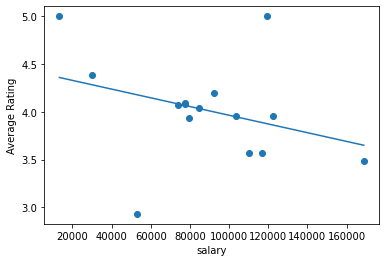

In [56]:
plt.scatter(dept_avg['salary'], dept_avg['avg_rating'])
plt.xlabel('salary')
plt.ylabel('Average Rating')

m,b = np.polyfit(dept_avg['salary'], dept_avg['avg_rating'], 1)
print(m)
print(b)

plt.plot(dept_avg['salary'], m * dept_avg['salary'] + b)

plt.show()


-3.47760929204505e-06
4.192418795804199


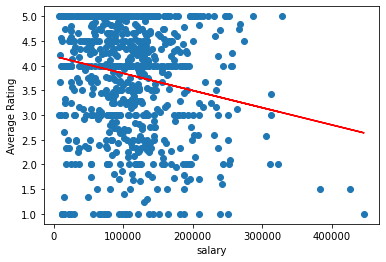

In [57]:
prof_salary = matched_salaries.dropna(subset = ['avg_rating'])

prof_salary = prof_salary[prof_salary['position'].str.contains("Professor") | prof_salary['position'].str.contains("Lecturer")]

plt.scatter(prof_salary['salary'], prof_salary['avg_rating'])
plt.xlabel('salary')
plt.ylabel('Average Rating')

m,b = np.polyfit(prof_salary['salary'], prof_salary['avg_rating'], 1)
print(m)
print(b)

plt.plot(prof_salary['salary'], m * prof_salary['salary'] + b, color = 'red')

plt.show()

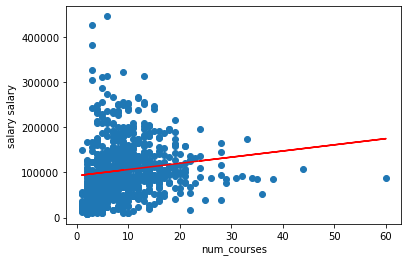

In [58]:
prof_salary = matched_salaries.dropna(subset = ['avg_rating'])


# print(prof_salary)

plt.scatter(prof_salary['num_courses'], prof_salary['salary'])
plt.xlabel('num_courses')
plt.ylabel('salary salary')

m,b = np.polyfit(prof_salary['num_courses'], prof_salary['salary'], 1)
# print(m)
# print(b)

plt.plot(prof_salary['num_courses'], m * prof_salary['num_courses'] + b, color = 'red')

plt.show()

In [59]:
matched_salaries.corr()

,salary,avg_rating,num_courses
salary,1.000000,-0.187235,0.163427
avg_rating,-0.187235,1.000000,-0.026072
num_courses,0.163427,-0.026072,1.000000


[Text(0, 0.5, 'salary'),
 Text(0, 1.5, 'avg_rating'),
 Text(0, 2.5, 'num_courses')]

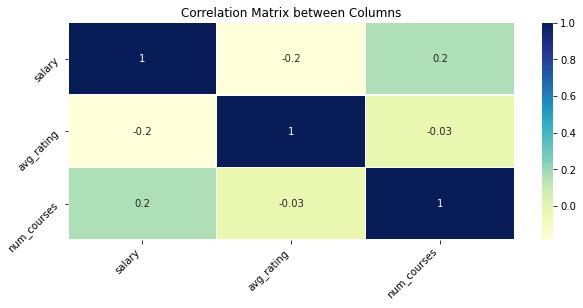

In [60]:
plt.subplots(figsize = (10,4))
g = sns.heatmap(matched_salaries.corr(), annot = True, cmap = "YlGnBu", fmt = '.1g', linewidths=.5,)

g.set_title("Correlation Matrix between Columns")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')

In [61]:
dept_features = pd.get_dummies(matched_salaries['department'], drop_first = True, prefix = 'dept')
# print(dept_features)

std_features = matched_salaries[['avg_rating', 'salary', 'num_courses']]

#combine our data
comb_features = pd.concat([std_features, dept_features], axis = 1)
# for i in filter(lambda i : i!= 'AGNR', matched_salaries['department'].unique()):
#     comb_features['salary*' + i] = comb_features['dept_' + i]*comb_features['salary']


[Text(0, 0.5, 'avg_rating'),
 Text(0, 1.5, 'salary'),
 Text(0, 2.5, 'num_courses'),
 Text(0, 3.5, 'dept_ARCH'),
 Text(0, 4.5, 'dept_ARHU'),
 Text(0, 5.5, 'dept_BMGT'),
 Text(0, 6.5, 'dept_BSOS'),
 Text(0, 7.5, 'dept_CMNS'),
 Text(0, 8.5, 'dept_EDUC'),
 Text(0, 9.5, 'dept_ENGR'),
 Text(0, 10.5, 'dept_EXST'),
 Text(0, 11.5, 'dept_INFO'),
 Text(0, 12.5, 'dept_JOUR'),
 Text(0, 13.5, 'dept_PLCY'),
 Text(0, 14.5, 'dept_SPHL'),
 Text(0, 15.5, 'dept_SVPAAP'),
 Text(0, 16.5, 'dept_UGST'),
 Text(0, 17.5, 'dept_VPR')]

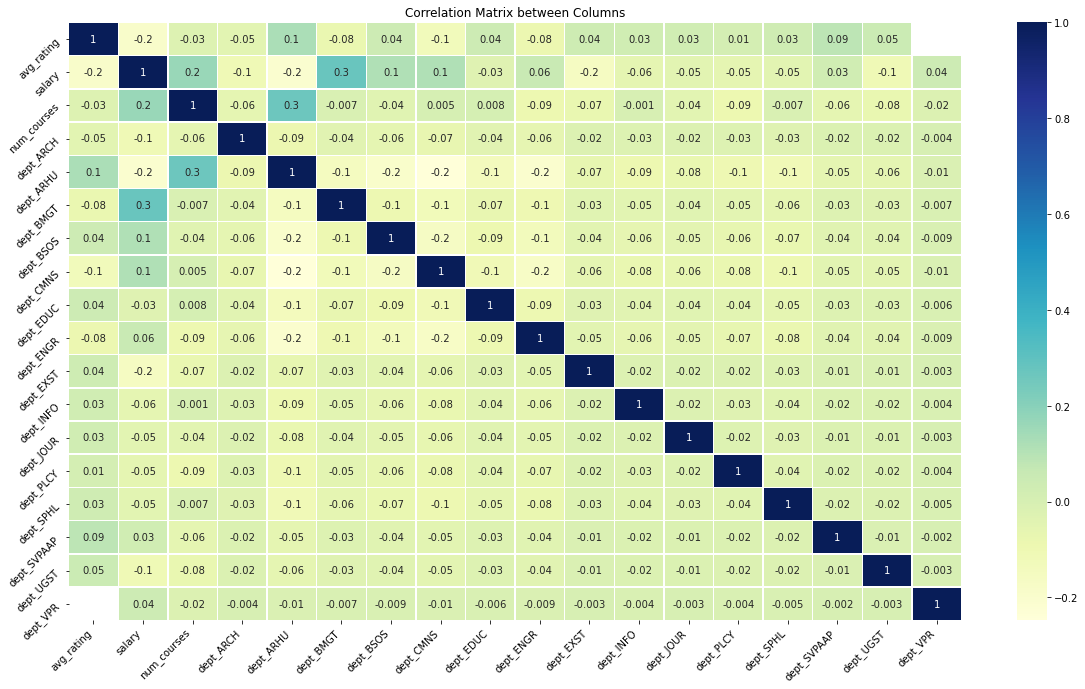

In [62]:
plt.subplots(figsize = (20,11))
g = sns.heatmap(comb_features.corr(), annot = True, cmap = "YlGnBu", fmt = '.1g', linewidths=.5,)

g.set_title("Correlation Matrix between Columns")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')

going back


In [63]:
# def convert_to_num_rep(s):
#     if(pd.isnull(s)):
#         return 0
#     nums = map(lambda c: str(ord(c)) , list(s))
#     return int("".join(list(nums)))

def get_salary(x): 
    return matched_salaries.loc[x.prof_df_id]["salary"]
def get_department(x):
    return matched_salaries.loc[x.prof_df_id]["department"]
    
def map_grades(g): 
    if(pd.isnull(g)):
        return np.nan
    
    d = {'A': 90, "B": 80, "C": 70, "D": 60, "F": 50}
    match = re.search('[a-z|A-Z]', g, re.IGNORECASE)
    if(match == None):
        return np.nan
    val = d.get(match.group(0))
    return val if val != None else np.nan

# reviews_df['course_num'] = reviews_df.apply(lambda x: convert_to_num_rep(x.course), axis=1)
reviews_df['grade_num'] = reviews_df.apply(lambda x: map_grades(x.expected_grade), axis=1)
reviews_df['department'] = reviews_df.apply(lambda x: get_department(x), axis=1)
reviews_df['salary'] = reviews_df.apply(lambda x: get_salary(x), axis=1)
reviews_df.head()

,slug,rating,expected_grade,course,review,prof_df_id,grade_num,department,salary
0,kruglanski,2,NaN,PSYC489H,"DO NOT TAKE PSYC489H ""Motivated Social Cogniti...",0,NaN,BSOS,322501.74
1,finkle,5,B+,ECON306,I really suggest Aaron Finkle for anyone who n...,1,80.0,BSOS,75054.05
2,finkle,2,A-,ECON306,Only parts of the syllabus were published at a...,1,90.0,BSOS,75054.05
3,swanlek,5,A+,COMM107,This prof is the COOLEST you could ever have. ...,4,90.0,ARHU,37087.20
4,swanlek,5,A+,COMM107,Aaron is the NICEST guy ever! He is incredibly...,4,90.0,ARHU,37087.20


In [64]:
# DO GET DUMMIES

,rating,prof_df_id,grade_num,salary
rating,1.000000,0.012995,0.440850,-0.052677
prof_df_id,0.012995,1.000000,0.040381,-0.075624
grade_num,0.440850,0.040381,1.000000,-0.061605
salary,-0.052677,-0.075624,-0.061605,1.000000


## Hypothesis Testing

In [67]:
missing_grades = reviews_df[pd.isnull(reviews_df["grade_num"])]
missing_grades

,slug,rating,expected_grade,course,review,prof_df_id,grade_num,department,salary
0,kruglanski,2,NaN,PSYC489H,"DO NOT TAKE PSYC489H ""Motivated Social Cogniti...",0,NaN,BSOS,322501.74
7,bhatele,5,NaN,NaN,Awesome professor!,9,NaN,CMNS,174021.38
12,jawahery,4,NaN,PHYS405,Phys 405 is difficult. It just is. Now that we...,12,NaN,CMNS,255121.04
20,hassam,5,NaN,PHYS121,Class is strait forward. Attend lecture and pr...,19,NaN,CMNS,129624.72
22,hassam,4,NaN,PHYS601,Prof. Hassam lays a lot of stress on students ...,19,NaN,CMNS,129624.72
...,...,...,...,...,...,...,...,...,...
5296,vishkin,2,NaN,ENEE446,Lectures were dry and very text dense - think ...,2178,NaN,AGNR,154039.62
5299,vishkin,1,NaN,ENEE641,His homework is straight out of the posted sol...,2178,NaN,AGNR,154039.62
5302,vishkin,1,NaN,NaN,If you are forced on gunpoint to take his cour...,2178,NaN,AGNR,154039.62
5306,hacquard,2,NaN,HONR218L,I did not enjoy this class. I expected it to ...,2179,NaN,CMNS,83422.01


In [69]:
non_missing_grades = reviews_df.dropna()
non_missing_grades

,slug,rating,expected_grade,course,review,prof_df_id,grade_num,department,salary
1,finkle,5,B+,ECON306,I really suggest Aaron Finkle for anyone who n...,1,80.0,BSOS,75054.05
2,finkle,2,A-,ECON306,Only parts of the syllabus were published at a...,1,90.0,BSOS,75054.05
3,swanlek,5,A+,COMM107,This prof is the COOLEST you could ever have. ...,4,90.0,ARHU,37087.20
4,swanlek,5,A+,COMM107,Aaron is the NICEST guy ever! He is incredibly...,4,90.0,ARHU,37087.20
5,swanlek,5,A+,COMM107,"Professor Swanlek, if you're reading this, YOU...",4,90.0,ARHU,37087.20
...,...,...,...,...,...,...,...,...,...
5295,slocum,5,A+,HONR238C,"Pretty interesting class, get to listen to gue...",2174,90.0,SPHL,104235.12
5297,vishkin,5,B,ENEE446,"ENEE446 is a very insightful course, which in ...",2178,80.0,AGNR,154039.62
5303,hacquard,3,A,HONR218L,Hacquard gave a capable and comprehensive surv...,2179,90.0,CMNS,83422.01
5304,hacquard,4,A,HONR218L,I wasn't going to review this until I saw the ...,2179,90.0,CMNS,83422.01


In [87]:
partition = math.floor(len(non_missing_grades.index) / 3) * 2
train_sample = non_missing_grades.iloc[0:partition, 0:]
test_sample =non_missing_grades.iloc[partition:, 0:]

In [89]:
test_sample
train_sample

,slug,rating,expected_grade,course,review,prof_df_id,grade_num,department,salary
1,finkle,5,B+,ECON306,I really suggest Aaron Finkle for anyone who n...,1,80.0,BSOS,75054.05
2,finkle,2,A-,ECON306,Only parts of the syllabus were published at a...,1,90.0,BSOS,75054.05
3,swanlek,5,A+,COMM107,This prof is the COOLEST you could ever have. ...,4,90.0,ARHU,37087.20
4,swanlek,5,A+,COMM107,Aaron is the NICEST guy ever! He is incredibly...,4,90.0,ARHU,37087.20
5,swanlek,5,A+,COMM107,"Professor Swanlek, if you're reading this, YOU...",4,90.0,ARHU,37087.20
...,...,...,...,...,...,...,...,...,...
3532,zhou_naijun,4,A,GEOG373,Zhou is a pleasant professor. The other review...,1488,90.0,ARHU,76141.79
3533,zhou_naijun,3,A,GEOG373,"The class is pretty straightforward-3 exams, e...",1488,90.0,ARHU,76141.79
3536,ratnapala,4,B+,ARTT255,"He is very, I mean VERY chill. Knowledgeable a...",1495,80.0,CMNS,51510.00
3537,tchetcherina,5,A,STAT440,The exam and final were fair. She taught by go...,1496,90.0,ARHU,19975.78


In [84]:
train_sample

,slug,rating,expected_grade,course,review,prof_df_id,grade_num,department,salary
1,finkle,5,B+,ECON306,I really suggest Aaron Finkle for anyone who n...,1,80.0,BSOS,75054.05
2,finkle,2,A-,ECON306,Only parts of the syllabus were published at a...,1,90.0,BSOS,75054.05
3,swanlek,5,A+,COMM107,This prof is the COOLEST you could ever have. ...,4,90.0,ARHU,37087.20
4,swanlek,5,A+,COMM107,Aaron is the NICEST guy ever! He is incredibly...,4,90.0,ARHU,37087.20
5,swanlek,5,A+,COMM107,"Professor Swanlek, if you're reading this, YOU...",4,90.0,ARHU,37087.20
...,...,...,...,...,...,...,...,...,...
2621,dorsey,5,A-,CCJS100,"Really awesome and funny professor, I highly r...",1119,90.0,ARHU,44092.61
2622,dorsey,5,A-,CCJS100,"Amazing professor, funny, slides are easy to f...",1119,90.0,ARHU,44092.61
2623,dorsey,5,B,CCJS105,I could not recommend a professor more than I ...,1119,80.0,ARHU,44092.61
2624,dorsey,4,A,CCJS105,Sometimes I get the feeling he doesn’t know wh...,1119,90.0,ARHU,44092.61
